# Liesel-GAM Demo Notebook

## Setup and Imports

In [7]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [8]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

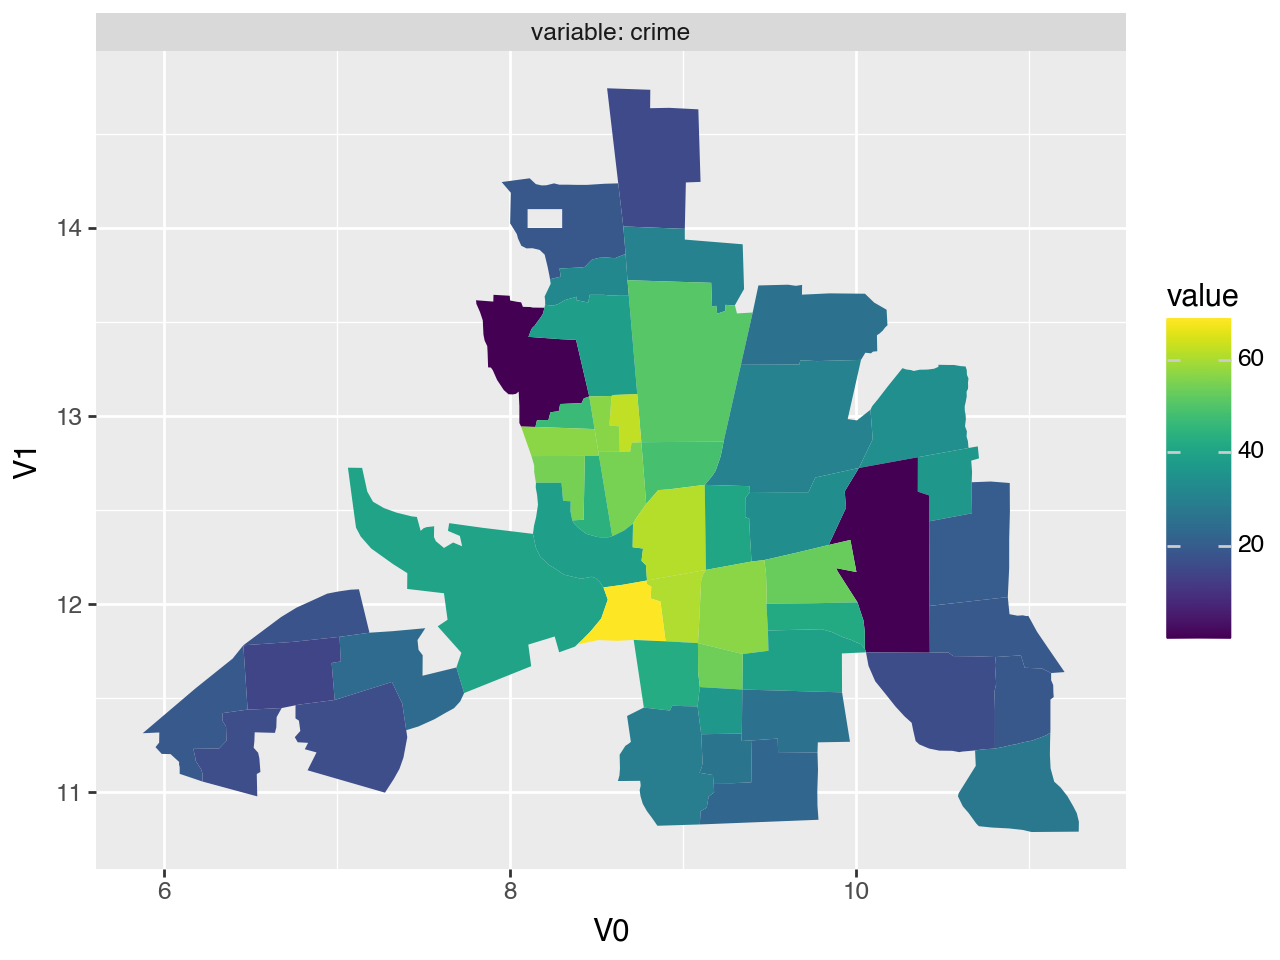

In [9]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

In [10]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y,label,observed
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076,0,True
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624,1,True
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719,2,True
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962,3,True
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366,4,True


## Model Definition

### Setup response model

In [11]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [12]:
loc += tb.lin("area")

# I use scale=1.0 for demo; otherwise there's no nonlinearity
smooth = tb.ps("income", scale=1.0)
loc += tb.vc("area", by=smooth)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


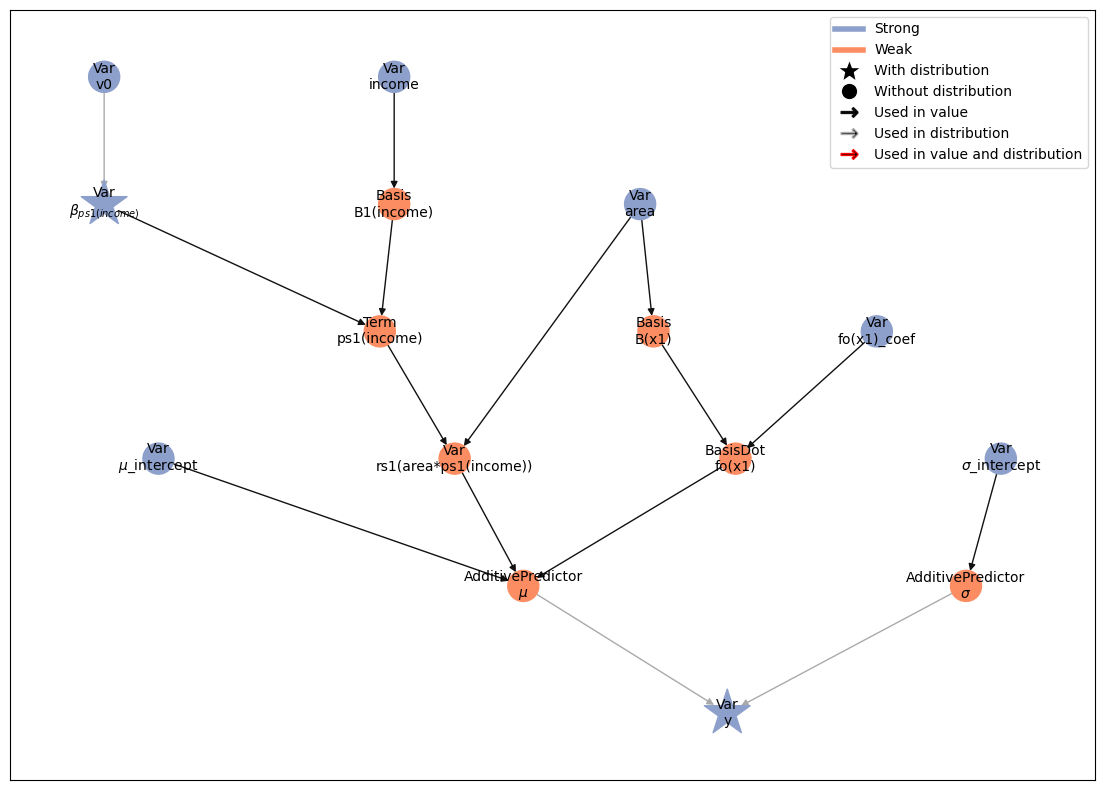

In [13]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [14]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ps1(income)}$', 'fo(x1)_coef'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  4.68chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1124.78chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1339.61chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - S

### MCMC summary

In [15]:
summary = gs.Summary(results)
summary

Parameter summary:

                                kernel       mean         sd     q_0.05  \
parameter             index                                               
$\beta_{ps1(income)}$ (0,)   kernel_02  -0.017041   1.005140  -1.695724   
                      (1,)   kernel_02   0.004323   1.008730  -1.688086   
                      (2,)   kernel_02  -0.006156   0.989219  -1.634072   
                      (3,)   kernel_02   0.006050   0.986724  -1.589285   
                      (4,)   kernel_02  -0.016680   0.988345  -1.635443   
                      (5,)   kernel_02  -0.033598   0.992605  -1.660588   
                      (6,)   kernel_02  -0.018437   1.013386  -1.651243   
                      (7,)   kernel_02  -0.026744   0.969078  -1.625545   
                      (8,)   kernel_02   0.012973   1.003825  -1.640678   
                      (9,)   kernel_02   0.040622   1.019711  -1.617988   
                      (10,)  kernel_02   0.041093   1.000145  -1.602983   
                      (11,)  kernel_02  -0.033002   0.998993  -1.709235   
                      (12,)  kernel_02  -0.023216   0.988000  -1.664245   
                      (13,)  kernel_02  -0.113448   0.991577  -1.747315   
                      (14,)  kernel_02  -0.184439   0.984074  -1.798083   
                      (15,)  kernel_02  -0.230327   0.984781  -1.871872   
                      (16,)  kernel_02   0.648062   0.938808  -0.879880   
                      (17,)  kernel_02   0.675485   0.687413  -0.463166   
                      (18,)  kernel_02 -11.199864   2.843119 -15.861211   
$\mu$_intercept       ()     kernel_01  43.536007   3.358394  38.013159   
$\sigma$_intercept    ()     kernel_00   2.580148   0.106398   2.411630   
fo(x1)_coef           (0,)   kernel_03 -35.820210  15.234740 -60.560727   

                                 q_0.5     q_0.95  sample_size     ess_bulk  \
parameter             index                                                   
$\beta_{ps1(income)}$ (0,)   -0.007136   1.631654         4000  3588.395597   
                      (1,)    0.026638   1.636846         4000  3569.101422   
                      (2,)   -0.017613   1.605809         4000  3384.673870   
                      (3,)    0.007579   1.604254         4000  3292.068278   
                      (4,)   -0.017565   1.642629         4000  3717.128454   
                      (5,)   -0.028457   1.618918         4000  3523.706347   
                      (6,)   -0.024878   1.611973         4000  3466.472485   
                      (7,)   -0.033426   1.579765         4000  3836.049690   
                      (8,)    0.017879   1.661604         4000  2943.796215   
                      (9,)    0.048088   1.682534         4000  3586.905143   
                      (10,)   0.031496   1.647283         4000  3270.788606   
                      (11,)  -0.016085   1.595872         4000  3503.953036   
                      (12,)  -0.018124   1.633957         4000  3664.084070   
                      (13,)  -0.104845   1.500879         4000  3431.217920   
                      (14,)  -0.183457   1.402010         4000  3507.827502   
                      (15,)  -0.212890   1.320558         4000  2995.815194   
                      (16,)   0.653186   2.201374         4000  3373.975781   
                      (17,)   0.685932   1.816057         4000  3220.941129   
                      (18,) -11.237850  -6.515845         4000  3018.391082   
$\mu$_intercept       ()     43.568546  49.014632         4000  3423.462792   
$\sigma$_intercept    ()      2.576766   2.760765         4000  3534.452373   
fo(x1)_coef           (0,)  -35.868176 -10.916432         4000  3284.107515   

                                ess_tail      rhat  
parameter             index                         
$\beta_{ps1(income)}$ (0,)   3809.942889  1.000032  
                      (1,)   3858.044929  0.999865  
                      (2,)   3630.206376  1.000290  
                 

## Plots

In [16]:
samples = results.get_posterior_samples()

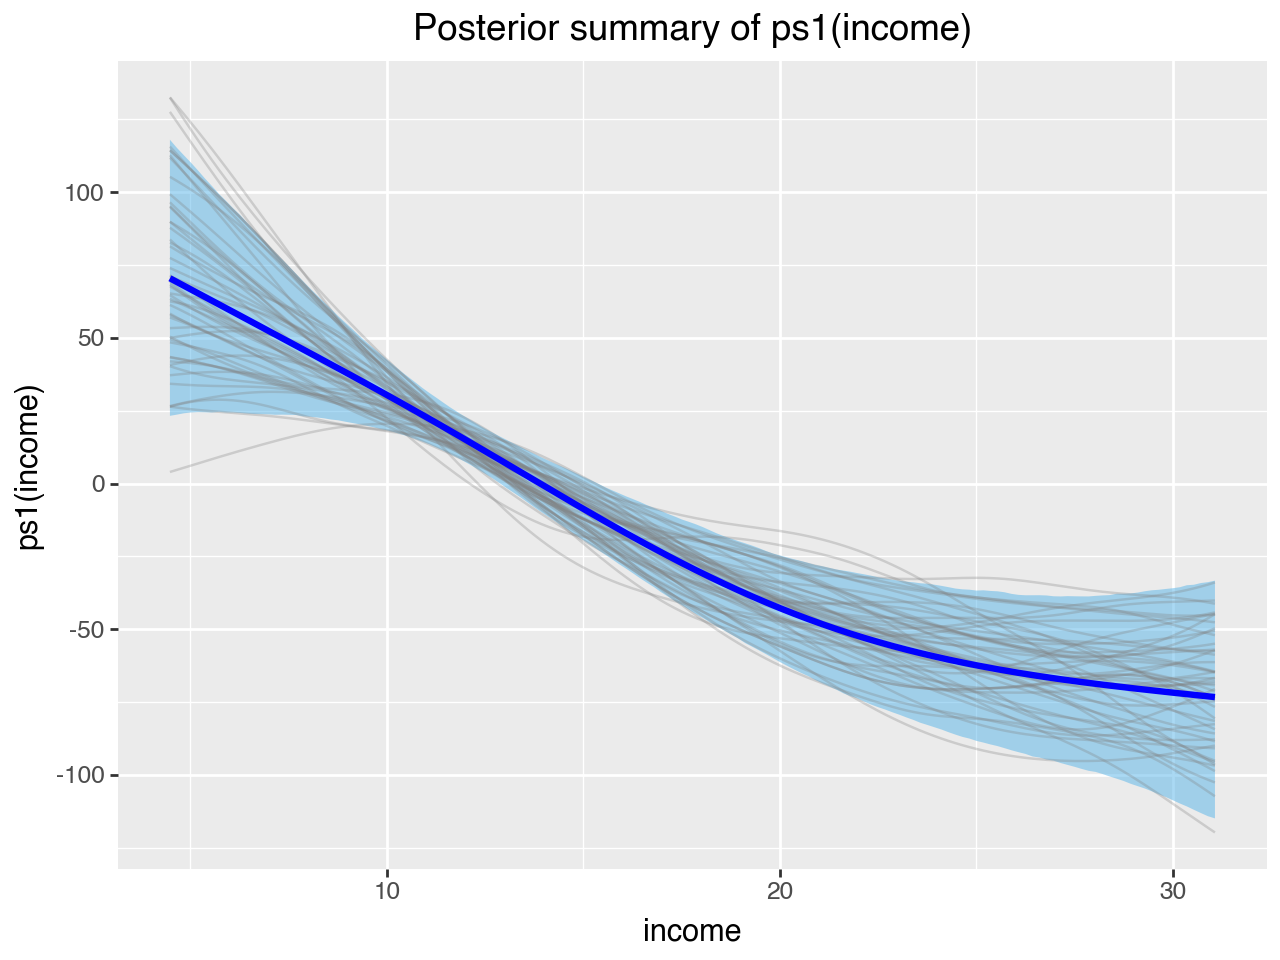

In [17]:
gam.plot_1d_smooth(term=model.vars["ps1(income)"], samples=samples)